# Detecting Corporate Events using 8-K Filings with FinFeedAPI

## Introduction

Form 8-K filings are used by public companies to disclose significant events that shareholders should be aware of between periodic reports (10-Q and 10-K). These events are categorized by specific item numbers (e.g., Item 1.01 for material definitive agreements, Item 5.02 for departure/election of directors or officers).

This notebook demonstrates how to use the FinFeedAPI to:
1.  **Fetch 8-K Filings:** Retrieve 8-K filings for a specific period or set of companies using `/v1/filings`.
2.  **Identify Specific Events:** Filter filings based on the reported item numbers using:
    * The `items_contain` parameter in `/v1/filings`.
    * Programmatically checking items extracted using `/v1/extractor`.
3.  **Analyze Event Frequency:** Track how often specific events occur over time.
4.  **Extract Event Details:** Use `/v1/extractor/item` to get the specific text associated with a reported event.

## Environment Setup

In [1]:
pip install api-bricks-sec-api-rest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.1 MB/s eta 0:00:00


In [32]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
from datetime import datetime
import os
from IPython.display import display
from collections import Counter # For counting item frequencies
import api_bricks_sec_api_rest

# --- API Configuration ---
API_KEY = "YOUR_API_KEY_HERE"  # <--- REPLACE THIS WITH YOUR ACTUAL KEY!
api_client = api_bricks_sec_api_rest.ApiClient(header_name="Authorization", header_value=API_KEY)

# --- Analysis Parameters ---
# Define the event item number(s) to track
# Common examples:
# 1.01: Entry into a Material Definitive Agreement
# 2.01: Completion of Acquisition or Disposition of Assets
# 5.02: Departure of Directors or Certain Officers; Election of Directors; Appointment of Certain Officers...
# 7.01: Regulation FD Disclosure
# 8.01: Other Events
TARGET_EVENT_ITEM = "5.02" # Example: Track executive/director changes

# Define time range
end_date = datetime.now().strftime('%Y-%m-%d')
start_date_dt = datetime.now() - pd.DateOffset(years=1) # Look back 1 year
start_date = start_date_dt.strftime('%Y-%m-%d')

# --- Plotting Configuration ---
try: plt.style.use('seaborn-v0_8-darkgrid')
except OSError: print("Seaborn style not found, using default."); plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 7)

## 1. Fetching 8-K Filings (Method 1: Using `items_contain`)

The `/v1/filings` endpoint has an `items_contain` parameter which *might* be used to directly filter for 8-Ks containing a specific item number. This is often the most efficient method if the API supports it well.

**Note:** The effectiveness of `items_contain` depends on how the backend indexes the 'items' field. Test if it reliably finds the desired item number.

In [9]:
from api_bricks_sec_api_rest.rest import ApiException

print(f"Method 1: Fetching 8-K filings containing Item '{TARGET_EVENT_ITEM}' using 'items_contain'...")

event_filings_m1 = []
current_page = 1
page_size = 200

api_instance = api_bricks_sec_api_rest.FilingMetadataApi(api_client)

while True:
    try:
      page_data = api_instance.v1_filings_get (
        form_type = "8-K",
        filling_date_start = start_date,
        filling_date_end = end_date,
        items_contain = TARGET_EVENT_ITEM, # Direct filter attempt
        page_size = page_size,
        page_number = current_page,
        sort_by = "FilingDate",
        sort_order = "desc"
      )
      if page_data is not None and isinstance(page_data, list) and len(page_data) > 0:
          event_filings_m1.extend(page_data)
          print(f"  Fetched page {current_page}, {len(page_data)} records. Total: {len(event_filings_m1)}")
          if len(page_data) < page_size: print("  Last page reached."); break
          current_page += 1
      else:
          if page_data == []: print(f"  No more data found on page {current_page}.")
          else: print(f"  API error or unexpected response on page {current_page}. Stopping fetch.")
          break
    except ApiException as e:
        print("Exception when calling FilingMetadataApi->v1_filings_get: %s\n" % e)

# Process results from Method 1
if event_filings_m1:
    event_filings_m1_df = pd.DataFrame.from_records([vars(x) for x in event_filings_m1])
    date_columns = ['filing_date', 'report_date', 'acceptance_date_time']
    for col in date_columns:
        if col in event_filings_m1_df.columns:
            event_filings_m1_df[col] = pd.to_datetime(event_filings_m1_df[col], errors='coerce')
    print(f"\nMethod 1 found {len(event_filings_m1_df)} filings potentially containing Item {TARGET_EVENT_ITEM}.")
    display(event_filings_m1_df[['filing_date', 'cik', 'accession_number', 'items']].head())
else:
    print(f"\nMethod 1: No 8-K filings found containing Item {TARGET_EVENT_ITEM} using 'items_contain'.")
    event_filings_m1_df = pd.DataFrame()

Method 1: Fetching 8-K filings containing Item '5.02' using 'items_contain'...
  Fetched page 1, 200 records. Total: 200
  Fetched page 2, 200 records. Total: 400
  Fetched page 3, 200 records. Total: 600
  Fetched page 4, 200 records. Total: 800
  Fetched page 5, 200 records. Total: 1000
  Fetched page 6, 200 records. Total: 1200
  Fetched page 7, 200 records. Total: 1400
  Fetched page 8, 200 records. Total: 1600
  Fetched page 9, 200 records. Total: 1800
  Fetched page 10, 200 records. Total: 2000
  Fetched page 11, 200 records. Total: 2200
  Fetched page 12, 200 records. Total: 2400
  Fetched page 13, 200 records. Total: 2600
  Fetched page 14, 200 records. Total: 2800
  Fetched page 15, 200 records. Total: 3000
  Fetched page 16, 200 records. Total: 3200
  Fetched page 17, 200 records. Total: 3400
  Fetched page 18, 200 records. Total: 3600
  Fetched page 19, 200 records. Total: 3800
  Fetched page 20, 200 records. Total: 4000
  Fetched page 21, 200 records. Total: 4200
  Fetched 

,filing_date,cik,accession_number,items
0,2024-06-26,1750,0001104659-24-075153,5.02
1,2025-01-08,1750,0001104659-25-001753,5.02
2,2025-03-19,1750,0001104659-25-025564,"5.02,9.01"
3,2024-11-15,1800,0001104659-24-119717,5.02
4,2025-05-01,1800,0001104659-25-043508,5.02


## 2. Fetching 8-K Filings (Method 2: Fetch All, then Extract & Filter)

If `items_contain` is unreliable or not specific enough, an alternative is to fetch all 8-K filings within the period and then use the `/v1/extractor` endpoint for each filing to check its actual items. This is more robust but requires significantly more API calls.

**Caution:** This method can be very API-intensive, especially over long periods or for many companies. Use with care and consider potential API limits/costs. We will only demonstrate the concept on a small subset.


In [34]:
print("\nMethod 2: Fetching all 8-Ks first, then extracting items (demonstrated on a small sample).")

# Fetch a small sample of *all* 8-Ks in the period first
sample_size = 20 # Limit for demonstration

all_8k_sample_list = api_instance.v1_filings_get (
    form_type = "8-K",
    filling_date_start = start_date,
    filling_date_end = end_date,
    page_size = sample_size,
    page_number = current_page,
    sort_by = "FilingDate",
    sort_order = "desc"
)
event_filings_m2 = []

api_instance2 = api_bricks_sec_api_rest.ContentExtractionApi(api_client)

if all_8k_sample_list and isinstance(all_8k_sample_list, list):
    print(f"\nFetched {len(all_8k_sample_list)} recent 8-Ks. Now extracting items to find '{TARGET_EVENT_ITEM}'...")
    for filing_meta in all_8k_sample_list:
        accession_no = filing_meta.accession_number
        if not accession_no: continue

        print(f"  Checking {accession_no}...")

        extracted_data = api_instance2.v1_extractor_get (
            accession_number = accession_no
        )

        if extracted_data is not None:
            found = False
            for item in extracted_data.items:
                item_num = item.item_number
                # Check if the target item number is present (allow for variations like "Item 5.02")
                if item_num and TARGET_EVENT_ITEM.replace(".", "") in item_num:
                    print(f"    Found Item {TARGET_EVENT_ITEM} in {accession_no}!")
                    # Add the original metadata (or extracted data) to our list
                    event_filings_m2.append({
                      "metadata": filing_meta,
                      "extracted_items": extracted_data.items
                    })
                    found = True
                    break # Stop checking items for this filing once found
            # if not found: print(f"    Item {TARGET_EVENT_ITEM} not found.") # Optional: uncomment for verbose output
        else:
            print(f"    Could not extract items for {accession_no}.")
        # Add a small delay to avoid hitting rate limits if any
        # import time; time.sleep(0.2) # Consider adding delays between extractor calls

    print(f"\nMethod 2 identified {len(event_filings_m2)} filings containing Item {TARGET_EVENT_ITEM} from the sample of {len(all_8k_sample_list)}.")
    if event_filings_m2:
        flattened_data_list = [
            {**item['metadata'].__dict__.copy(), 'extracted_items': [item.__dict__ for item in item['extracted_items']]}
            for item in event_filings_m2
        ]
        event_filings_m2_df = pd.DataFrame.from_records(flattened_data_list)
        # Convert dates if needed (might already be done if reusing from all_8k_df)
        for col in ['filing_date', 'report_date', 'acceptance_date_time']:
             if col in event_filings_m2_df.columns:
                 event_filings_m2_df[col] = pd.to_datetime(event_filings_m2_df[col], errors='coerce')
        display(event_filings_m2_df[['filing_date', 'cik', 'accession_number']].head())
    else:
        event_filings_m2_df = pd.DataFrame()

else:
    print("\nCould not fetch initial sample of 8-K filings for Method 2.")
    event_filings_m2_df = pd.DataFrame()

# --- Choose which DataFrame to use for further analysis ---
# Method 1 is usually preferred if it works reliably.
if not event_filings_m1_df.empty:
    final_event_df = event_filings_m1_df
    print("\nUsing results from Method 1 for further analysis.")
elif not event_filings_m2_df.empty:
    final_event_df = event_filings_m2_df
    print("\nUsing results from Method 2 (sample) for further analysis.")
else:
    final_event_df = pd.DataFrame()
    print("\nNo event filings found using either method.")


Method 2: Fetching all 8-Ks first, then extracting items (demonstrated on a small sample).

Fetched 20 recent 8-Ks. Now extracting items to find '5.02'...
  Checking 0001193125-25-095039...
  Checking 0001193125-25-113839...
  Checking 0000022606-24-000014...
    Found Item 5.02 in 0000022606-24-000014!
  Checking 0001109357-24-000154...
  Checking 0001109357-24-000158...
  Checking 0001109357-24-000183...
  Checking 0001109357-25-000041...
  Checking 0001109357-25-000110...
  Checking 0000897101-24-000187...
  Checking 0000897101-24-000191...
  Checking 0000897101-24-000193...
  Checking 0000897101-24-000196...
    Found Item 5.02 in 0000897101-24-000196!
  Checking 0000897101-24-000218...
    Found Item 5.02 in 0000897101-24-000218!
  Checking 0000897101-24-000235...
  Checking 0000897101-24-000263...
  Checking 0000897101-24-000296...
    Found Item 5.02 in 0000897101-24-000296!
  Checking 0000897101-24-000329...
  Checking 0000897101-24-000335...
  Checking 0000897101-24-000401...

,filing_date,cik,accession_number
0,2024-08-05,22606,0000022606-24-000014
1,2024-05-23,22701,0000897101-24-000196
2,2024-06-03,22701,0000897101-24-000218
3,2024-07-08,22701,0000897101-24-000296
4,2024-08-23,22701,0000897101-24-000401



Using results from Method 1 for further analysis.


## 3. Analyze Event Frequency Over Time

Let's plot the number of identified event filings per month.

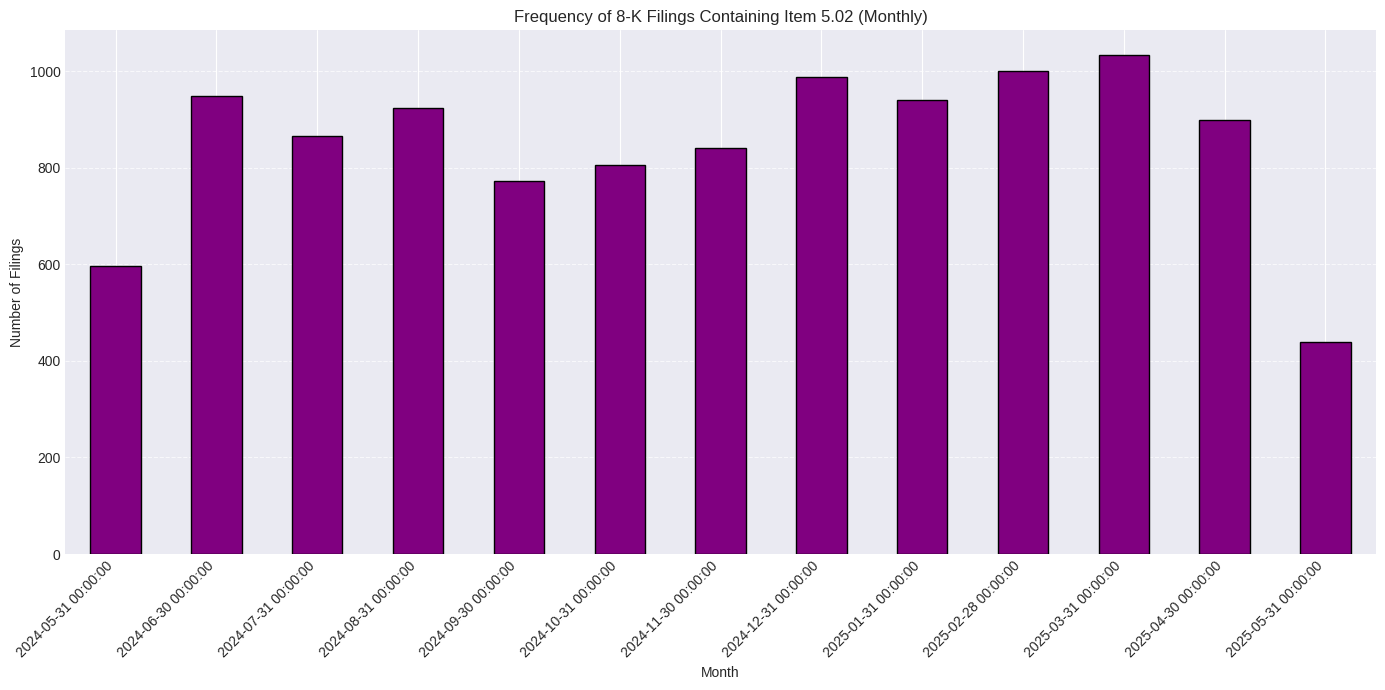

In [35]:
if not final_event_df.empty and 'filing_date' in final_event_df.columns:
    final_event_df = final_event_df.dropna(subset=['filing_date'])
    if not final_event_df.empty:
        # Resample by month and count
        events_by_month = final_event_df.set_index('filing_date').resample('ME').size()

        # Create the plot
        plt.figure(figsize=(14, 7))
        events_by_month.plot(kind='bar', color='purple', edgecolor='black')
        plt.title(f'Frequency of 8-K Filings Containing Item {TARGET_EVENT_ITEM} (Monthly)')
        plt.xlabel('Month')
        plt.ylabel('Number of Filings')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid filing dates after cleaning. Cannot plot frequency.")
else:
    print("No event filings data available to analyze frequency.")

## 4. Extract Specific Event Details

Let's take one of the identified filings and use `/v1/extractor/item` to get the precise text associated with the target event item number.

In [45]:
if not final_event_df.empty:
    # Select the most recent event filing found
    event_filing_to_extract = final_event_df.sort_values('filing_date', ascending=False).iloc[0]
    acc_no = event_filing_to_extract['accession_number']

    print(f"\nExtracting details for Item '{TARGET_EVENT_ITEM}' from filing: {acc_no}")

    event_content = api_instance2.v1_extractor_item_get (
        accession_number = acc_no,
        item_number = TARGET_EVENT_ITEM
    )

    if event_content is not None:
        print(f"\nContent for Item {TARGET_EVENT_ITEM} in {acc_no} (first 1500 chars):")
        print(event_content[:1500] + ('...' if len(event_content) > 1500 else ''))

else:
    print("\nNo event filings identified to extract details from.")


Extracting details for Item '5.02' from filing: 0000939057-25-000140

Content for Item 5.02 in 0000939057-25-000140 (first 1500 chars):
Departure of Directors or Certain Officers; Election of Directors; Appointment of Certain Officers; Compensatory Arrangements of Certain Officers Provident Financial Holdings, Inc. (“Corporation” or “Provident”), the holding company for Provident Savings Bank, F.S.B. (“Bank” or “Provident”), announced on May 12, 2025 that Peter C. Fan has been appointed Senior Vice President, Chief Financial Officer, and Corporate Secretary of the Corporation and the Bank, effective May 12, 2025. Mr. Fan, age 60, most recently served as Senior Vice President – Director of Finance and Treasury at Royal Business Bank a position he has held since February 2024. Prior to that, Mr. Fan was Senior Vice President – Finance at Pacific Western Bank from April 2014 to February 2024. Mr. Fan’s educational background includes a Master of Business Administration from the Universit

## Conclusion

This notebook explored two methods for identifying specific corporate events reported in Form 8-K filings using the FinFeedAPI:
1.  Direct filtering using the `/v1/filings` endpoint's `items_contain` parameter (efficient if reliable).
2.  Fetching all 8-Ks and then using `/v1/extractor` on each to check items (more robust but API-intensive).

We then visualized the frequency of the target event over time and demonstrated how to extract the specific textual details of the event using `/v1/extractor/item`.

This approach can be adapted to monitor various types of significant corporate events, providing timely insights into company activities. Remember to choose the most appropriate fetching method based on API behavior and your usage constraints.